<h1 style="color:#2F659C";>Qubit-like measurements with Presto</h1>
This notebook allows for using the presto and saving the data in QCodes databases using a custom driver developed for the Presto.

In [1]:
sample_name = 'bilbo_c1'              # name of the chip in the fridge
user = 'ncr'                          # who is performing measurements

date = '20221118'                     # when did the measurements started
description = 'pulsed_spectroscopy'   # super short description of what you are doing

<h3 style="color:#418FDB";>QCodes imports</h3>
Import the QCodes functions used in the measurement of this sample.

In [2]:
import sys, os
import time
from time import sleep, perf_counter

import matplotlib.pyplot as plt
import numpy as np
import tqdm.notebook as tqdm

# QCodes
import qcodes as qc
import time
from qcodes import (
    Measurement,
    experiments,
    initialise_database,
    initialise_or_create_database_at,
    load_by_guid,
    load_by_run_spec,
    load_experiment,
    load_last_experiment,
    load_or_create_experiment,
    new_experiment,
    validators
)
from qcodes.instrument.parameter import Parameter

from qcodes.logger.logger import start_all_logging, start_command_history_logger
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.interactive_widget import experiments_widget

In [3]:
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Scripts')

from QMETfunc.QMET_measurement import do0d, do1d, do2d, dond, LinSweep, LogSweep, formatString

<h2 style="color:#1C3C5C";>Station and database setup</h2>
Add the instruments to the station and start all the loggings related to the measurement. Then create or initialise the database where all the data will be saved.

In [4]:
data_dir = os.path.join(r'D:\QMET\Qubit' + '\\' + sample_name)

In [5]:
database_name = date + '_' + user + '_' + description
try :
    os.mkdir(data_dir)
except FileExistsError:
    pass

qc.initialise_or_create_database_at(data_dir + '\\' + database_name + '.db')
qc.config.core.db_location

'D:\\QMET\\Qubit\\bilbo_c1\\20221118_ncr_pulsed_spectroscopy.db'

In [6]:
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Drivers')
sys.path.append(r'C:\Users\nicolas.roch\Measurements\Drivers\presto-measure')

<h3 style="color:#418FDB";>Presto initialisation</h3>


In [7]:
import presto as prs
from IPPresto import ip_Presto

ADDRESS = "192.168.0.105"  # set address/hostname of Vivace here
EXT_REF = False  # set to True to use external 10 MHz reference

In [8]:
presto = ip_Presto('presto', ADDRESS)

STATION = qc.Station()
STATION.add_component(presto)
#STATION.close_all_registered_instruments()

[presto(ip_Presto)] Error getting or interpreting *IDN?: ''
Traceback (most recent call last):
  File "C:\Users\nicolas.roch\Miniconda3\envs\qubit\Lib\site-packages\qcodes\instrument\instrument.py", line 90, in get_idn
    idstr = self.ask("*IDN?")
            ^^^^^^^^^^^^^^^^^
  File "C:\Users\nicolas.roch\Miniconda3\envs\qubit\Lib\site-packages\qcodes\instrument\instrument.py", line 414, in ask
    raise e
  File "C:\Users\nicolas.roch\Miniconda3\envs\qubit\Lib\site-packages\qcodes\instrument\instrument.py", line 407, in ask
    answer = self.ask_raw(cmd)
             ^^^^^^^^^^^^^^^^^
  File "C:\Users\nicolas.roch\Miniconda3\envs\qubit\Lib\site-packages\qcodes\instrument\instrument.py", line 427, in ask_raw
    raise NotImplementedError(
NotImplementedError: ('Instrument ip_Presto has not defined an ask method', "asking '*IDN?' to <ip_Presto: presto>")


'presto'

<h2>Measurements</h2>

<h4>Resonant modes</h4>

In [9]:
f1 = 3.879e9
f2 = 4.003e9

<h2>Spectroscopy</h2>
The two modes of the arrays to be used to pulse and readout are analysed in frequency and phase.

In [22]:
from sweep import Sweep
from IPPresto import s21

<h4>Mode 1</h4>

In [17]:
f_center = f1
span = 20e6
rbw = 20e3
navg = 1001
amp = 0.01

spectroscopy_1 = Sweep( freq_center = f_center,
                        freq_span = span,
                        df = rbw,
                        num_averages = navg,
                        amp = amp,
                        output_port = 1,
                        input_port = 1 
                       )

mname = 's21_f%.2e_s%.2e_rbw%.2e_avg%.2f_a%.2f' % (f_center, span, rbw, navg, amp)
s21_param = s21(formatString(mname), presto, f_center, span, rbw, navg, amp)

In [18]:
measurement_name = "s21_spectroscopy_%.2e" % f1
exp = load_or_create_experiment(experiment_name = measurement_name, sample_name = sample_name)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

meas.write_period = 10
meas.register_parameter(s21_param)

In [19]:
spectroscopy_1.run(ADDRESS);
data = spectroscopy_1.qc_analyze()

# save in database
with meas.run() as datasaver:
    data = spectroscopy_1.qc_analyze()
    datasaver.add_result((s21_param, data))

Done in 57.1s                                                                  


Starting experimental run with id: 3. 


<h4>Mode 2</h4>

In [23]:
f_center = f2
span = 20e6
rbw = 20e3
navg = 1001
amp = 0.01

spectroscopy_2 = Sweep( freq_center = f2,
                        freq_span = 20e6,
                        df = 20e3,
                        num_averages = 101,
                        amp = 0.01,
                        output_port = 1,
                        input_port = 1 
                      )

mname = 's21_f%.2e_s%.2e_rbw%.2e_avg%.2f_a%.2f' % (f_center, span, rbw, navg, amp)
s21_param = s21(formatString(mname), presto, f_center, span, rbw, navg, amp)

In [24]:
measurement_name = "s21_spectroscopy_%.2e" % f2
exp = load_or_create_experiment(experiment_name = measurement_name, sample_name = sample_name)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

meas.write_period = 10
meas.register_parameter(s21_param)

In [28]:
spectroscopy_2.run(ADDRESS);
data = spectroscopy_2.qc_analyze()

# save in database
with meas.run() as datasaver:
    data = spectroscopy_2.qc_analyze()
    datasaver.add_result((s21_param, data))

Done in 12.8s                                                                  


Starting experimental run with id: 50. 


<h4>Test run (does not save data)</h4>

In [ ]:
spectroscopy_2.run(ADDRESS)
spectroscopy_2.analyze()

<h2>Two-tones measurement</h2>
Pumping on one resonance, reading on the other one.

In [10]:
from two_tone_power import TwoTonePower
from IPPresto import twotones

In [12]:
readout_freq = f2
control_freq_center = f1
control_freq_span = 50e6
rbw = 100e3
readout_amp = 0.01
num_averages = 101

# amplitudes
amp_start = 0.01
amp_stop = 1
amp_points = 21
control_amps = np.linspace(amp_start, amp_stop, amp_points)

ttones = TwoTonePower( readout_freq = readout_freq,
                       control_freq_center = control_freq_center,
                       control_freq_span = control_freq_span,
                       df = rbw,
                       readout_amp = readout_amp,
                       control_amp_arr = control_amps,
                       readout_port = 1,
                       control_port = 2,
                       input_port = 1,
                       num_averages = num_averages )


mname = 's21_rf%.2e_cf%.2e_cfspan%.2e_rbw%.2e_ra%.2f_castart%.2f_castop%.2e_cqpoints%.2e_avg%.2e' % ( readout_freq, 
                                                                                                      control_freq_center, 
                                                                                                      control_freq_span, 
                                                                                                      rbw, 
                                                                                                      readout_amp, 
                                                                                                      amp_start, 
                                                                                                      amp_stop, 
                                                                                                      amp_points,
                                                                                                      num_averages)

twotones_param = twotones(formatString(mname), presto, readout_freq, control_freq_center, control_freq_span, 
                          rbw, readout_amp, amp_start, amp_stop, amp_points, num_averages)

In [19]:
measurement_name = "twotones_spectroscopy_c%.2e_span%.2e" % ( control_freq_center, control_freq_span )
exp = load_or_create_experiment(experiment_name = measurement_name, sample_name = sample_name)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

meas.write_period = 10
meas.register_parameter(twotones_param)

In [20]:
ttones.run(ADDRESS);
data = ttones.qc_analyze()

# save in database
with meas.run() as datasaver:
    data = ttones.qc_analyze()
    datasaver.add_result((twotones_param, data))

Done in 2m 3.9s                                                                 


Data saved to: C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\data\two_tone_power_20221201_172141.h5
Starting experimental run with id: 9. 


<h4>Test run (does not save data)</h4>

In [19]:
ttones.run(ADDRESS)
ttones.analyze()

Done in 1m 18.1s                                                                


Data saved to: C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\data\two_tone_power_20221130_195001.h5


'C:\\Users\\nicolas.roch\\Measurements\\Drivers\\presto-measure\\data\\two_tone_power_20221130_195001.h5'

<h2>Two-tones pulsed measurement</h2>
Pumping on one resonance, reading on the other one, now with pulses.

In [14]:
from two_tone_pulsed import TwoTonePulsed
from IPPresto import twotones_pulsed

In [15]:
readout_freq = f2
control_freq_center = f1
control_freq_span = 50e6
control_freq_nr = 501
readout_amp = 0.04
control_amp = 0.8
readout_duration = 802e-9
control_duration = 602e-9
sample_duration = 402e-9
wait_delay = 5e-6
readout_sample_delay = 0.2e-6
num_averages = 10001

twotones_p = TwoTonePulsed( readout_freq = readout_freq,
                            control_freq_center = control_freq_center,
                            control_freq_span = control_freq_span,
                            control_freq_nr = control_freq_nr,
                            readout_amp = readout_amp,
                            control_amp = control_amp,
                            readout_duration = readout_duration,
                            control_duration = control_duration,
                            sample_duration = sample_duration,
                            readout_port = 1,
                            control_port = 2,
                            sample_port = 1,
                            wait_delay = wait_delay,
                            readout_sample_delay = readout_sample_delay,
                            num_averages = num_averages )

mname = 's21_rf%.2e_cf%.2e_cfspan%.2e_cfn%.2i_ra%.2f_ca%.2f_rt%.2e_ct%.2e_st%.2e_wd%.2e_rd%.2e_avg%.2i' % ( readout_freq,
                                                                                                      control_freq_center,
                                                                                                      control_freq_span,
                                                                                                      control_freq_nr,
                                                                                                      readout_amp,
                                                                                                      control_amp,
                                                                                                      readout_duration/1e-9,
                                                                                                      control_duration/1e-9,
                                                                                                      sample_duration/1e-9,
                                                                                                      wait_delay/1e-9,
                                                                                                      readout_sample_delay/1e-9,
                                                                                                      num_averages)

twotones_pulsed_param = twotones_pulsed( formatString(mname), presto, readout_freq, control_freq_center, control_freq_span,
                                         control_freq_nr, readout_amp,control_amp, readout_duration, control_duration, 
                                         sample_duration, wait_delay, readout_sample_delay, num_averages )

In [16]:
measurement_name = "twotones_pulsed_c%.2e_span%.2e" % ( control_freq_center, control_freq_span )
exp = load_or_create_experiment(experiment_name = measurement_name, sample_name = sample_name)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

meas.write_period = 10
meas.register_parameter(twotones_pulsed_param)

In [17]:
# averaging range in the sample time window, (0, 1) = average all
avg_range = (0.5, 1)

twotones_p.run(ADDRESS);
data = twotones_p.qc_analyze(avg_range)

# save in database
with meas.run() as datasaver:
    data = twotones_p.qc_analyze(avg_range)
    datasaver.add_result((twotones_pulsed_param, data))

Measurement sequence processed in 0.0e+00
Expected measurement time: 32.1s
Uploading measurement parameters: 313.3ms
Measurement completed in: 32.4s
Total time: 33.0s
Data saved to: C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\data\two_tone_pulsed_20221209_152755.h5
Starting experimental run with id: 34. 


<h4>Test run (does not save data)</h4>

Measurement sequence processed in 0.0e+00
Expected measurement time: 32.1s
Uploading measurement parameters: 105.5ms
Measurement completed in: 32.4s
Total time: 32.8s
Data saved to: C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\data\two_tone_pulsed_20221209_152042.h5
f0 = 3879114269.7479124 Hz
sigma = 1480740.8082680819 Hz


C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\two_tone_pulsed.py:349: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


[<Figure size 640x640 with 4 Axes>]

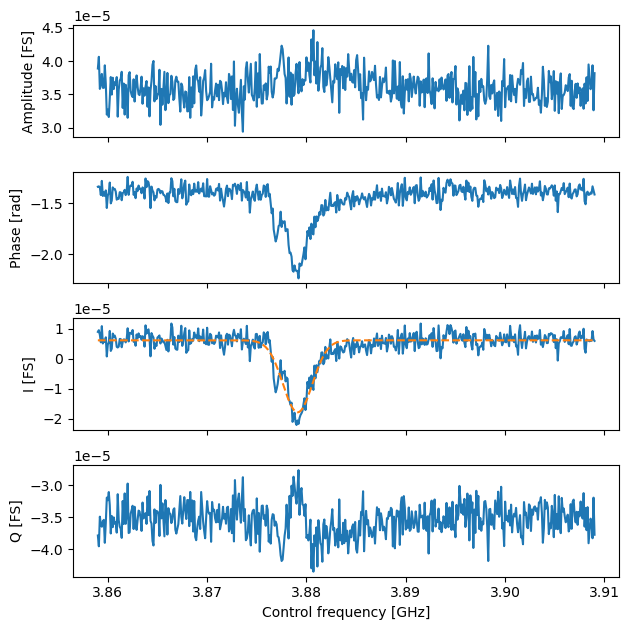

In [17]:
twotones_p.run(ADDRESS)
twotones_p.analyze()

<h2>Two-tones pulsed measurement, pulse amplitude variation</h2>
Pumping on one resonance, reading on the other one, now with pulses of different amplitude.

In [12]:
from two_tone_pulsed_amp import TwoTonePulsedAmp
from IPPresto import twotones_pulsed_amp

In [13]:
readout_freq = f2
control_freq_center = f1
control_freq_span = 50e6
control_freq_nr = 501
readout_amp = 0.04

readout_duration = 802e-9
control_duration = 602e-9
sample_duration = 402e-9
wait_delay = 5e-6
readout_sample_delay = 0.2e-6

# amplitude range
control_amp_start = 1.0
control_amp_stop = 0.02
control_amp_nr = 101
control_amps = np.linspace(control_amp_start, control_amp_stop, control_amp_nr)

num_averages = 10001 

twotones_pa = TwoTonePulsedAmp( readout_freq = readout_freq,
                                control_freq_center = control_freq_center,
                                control_freq_span = control_freq_span,
                                control_freq_nr = control_freq_nr,
                                readout_amp = readout_amp,
                                control_amps = control_amps,
                                readout_duration = readout_duration,
                                control_duration = control_duration,
                                sample_duration = sample_duration,
                                readout_port = 1,
                                control_port = 2,
                                sample_port = 1,
                                wait_delay = wait_delay,
                                readout_sample_delay = readout_sample_delay,
                                num_averages = num_averages )

mname = 's21_rf%.2e_cf%.2e_cfspan%.2e_cfn%.2i_ra%.2f_ca%.2fto%.2f_rt%.2e_ct%.2e_st%.2e_wd%.2e_rd%.2e_avg%.2i' % ( readout_freq,
                                                                                                      control_freq_center,
                                                                                                      control_freq_span,
                                                                                                      control_freq_nr,
                                                                                                      readout_amp,
                                                                                                      control_amp_start,
                                                                                                      control_amp_stop,
                                                                                                      readout_duration/1e-9,
                                                                                                      control_duration/1e-9,
                                                                                                      sample_duration/1e-9,
                                                                                                      wait_delay/1e-9,
                                                                                                      readout_sample_delay/1e-9,
                                                                                                      num_averages)

twotones_pa_param = twotones_pulsed_amp( formatString(mname), presto, readout_freq, control_freq_center, control_freq_span,
                                         control_freq_nr, readout_amp, control_amps, readout_duration,control_duration, 
                                         sample_duration, wait_delay, readout_sample_delay, num_averages )

In [14]:
measurement_name = "twotones_pa_c%.2e_span%.2e_a%.2fto%.2f" % ( control_freq_center, control_freq_span, 
                                                                control_amp_start, control_amp_stop )
exp = load_or_create_experiment(experiment_name = measurement_name, sample_name = sample_name)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

meas.write_period = 10
meas.register_parameter(twotones_pa_param)

In [15]:
# averaging range in the sample time window, (0, 1) = average all
avg_range = (0.5, 1)

twotones_pa.run(ADDRESS);
data = twotones_pa.qc_analyze(avg_range)

# save in database
with meas.run() as datasaver:
    data = twotones_pa.qc_analyze(avg_range)
    datasaver.add_result((twotones_pa_param, data))

Measurement starting. Amplitudes done:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 . Done.
Starting experimental run with id: 30. 


In [ ]:
# RICORDATI DI PROVARE QUELLO SENZA VARIAZIONE DI AMPIEZZA DI NUOVO.

<h4>Test run (does not save data)</h4>

In [24]:
# TBD
twotones_p.run(ADDRESS)
twotones_p.analyze()

Measurement sequence processed in 1.0ms
Expected measurement time: 5m 30.9s
Uploading measurement parameters: 104.2ms


KeyboardInterrupt: 

<h2>Ramsey measurement</h2>
Perform a Ramsey-type spectroscopy for the measurement of the mode's coherence time.

In [10]:
from ramsey_single import RamseySingle
from IPPresto import ramsey_single

In [11]:
readout_freq = f2
control_freq = f1
readout_amp = 0.1
control_amp = 0.85
readout_duration = 402e-9
control_duration = 202e-9
sample_duration = 402e-9
readout_port = 1
control_port = 2
sample_port = 1
wait_delay = 5e-6
readout_sample_delay =100e-9

# delays
delay_start = 0
delay_stop = 0.8e-6
delay_points = 101
delays = np.linspace(delay_start, delay_stop, delay_points)

num_averages = 50001

ramsey = RamseySingle( readout_freq = readout_freq,
                       control_freq = control_freq,
                       readout_amp = readout_amp,
                       control_amp = control_amp,
                       readout_duration = readout_duration,
                       control_duration = control_duration,
                       sample_duration = sample_duration,
                       delay_arr = delays,
                       readout_port = 1,
                       control_port = 2,
                       sample_port = 1,
                       wait_delay = wait_delay,
                       readout_sample_delay = readout_sample_delay,
                       num_averages = num_averages )

mname = 's21_rf%.2e_cf%.2e_ra%.2f_ca%.2f_rd%.2e_cd%.2e_sd%.2e_del%.2fto%.2e_ndel%.2i_wd%.2e_rsd%.2e_avg%.2i' % ( readout_freq,
                                                                                                                 control_freq,
                                                                                                                 readout_amp,
                                                                                                                 control_amp,
                                                                                                                 readout_duration/1e-9,
                                                                                                                 control_duration/1e-9,
                                                                                                                 sample_duration/1e-9,
                                                                                                                 delay_start/1e-9,
                                                                                                                 delay_stop/1e-9,
                                                                                                                 delay_points,
                                                                                                                 wait_delay/1e-9,
                                                                                                                 readout_sample_delay/1e-9,
                                                                                                                 num_averages ) 

ramsey_param = ramsey_single( formatString(mname), presto, readout_freq, control_freq, readout_amp, control_amp, readout_duration, 
                              control_duration, sample_duration, delays, wait_delay, readout_sample_delay, num_averages )

In [12]:
measurement_name = "ramsey_r%.2e_c%.2e" % ( readout_freq, control_freq )
exp = load_or_create_experiment(experiment_name = measurement_name, sample_name = sample_name)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

meas.write_period = 10
meas.register_parameter(ramsey_param)

In [26]:
# averaging range in the sample time window, (0, 1) = average all
avg_range = (0.25, 1)

ramsey.run(ADDRESS);
data = ramsey.qc_analyze(avg_range)

# save in database
with meas.run() as datasaver:
    data = ramsey.qc_analyze(avg_range)
    datasaver.add_result((ramsey_param, data))

Measurement sequence processed in 3.0ms
Expected measurement time: 31.3s
Uploading measurement parameters: 107.4ms
Measurement completed in: 31.6s
Total time: 32.0s
Data saved to: C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\data\ramsey_single_20221214_153135.h5
Starting experimental run with id: 88. 


<h4>Test run (does not save data)</h4>

In [17]:
ramsey.run(ADDRESS)

Measurement sequence processed in 6.0ms
Expected measurement time: 24.5s
Uploading measurement parameters: 110.6ms
Measurement completed in: 24.8s
Total time: 25.2s
Data saved to: C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\data\ramsey_single_20221209_164640.h5


TypeError: RamseySingle.analyze() got an unexpected keyword argument 'plot_all'

C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\ramsey_single.py:303: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


T2 time: 211235.6665186836 +- 63233272956.19777 us
detuning: 144121333.33832002 +- 350733.5901999335 Hz


C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\ramsey_single.py:342: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
C:\Users\nicolas.roch\Measurements\Drivers\presto-measure\ramsey_single.py:365: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


[<Figure size 640x480 with 2 Axes>,
 <Figure size 640x640 with 4 Axes>,
 <Figure size 640x480 with 1 Axes>]

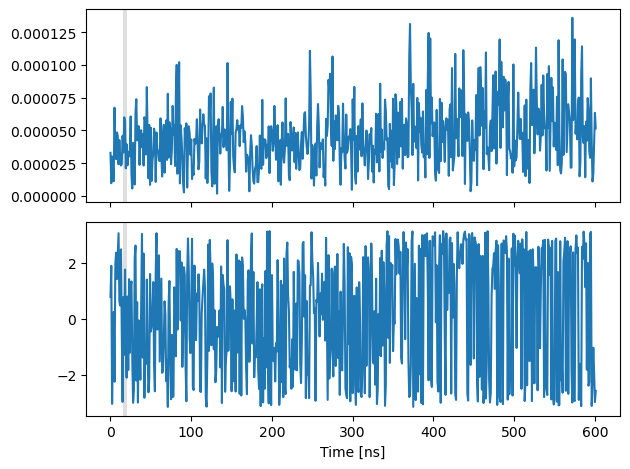

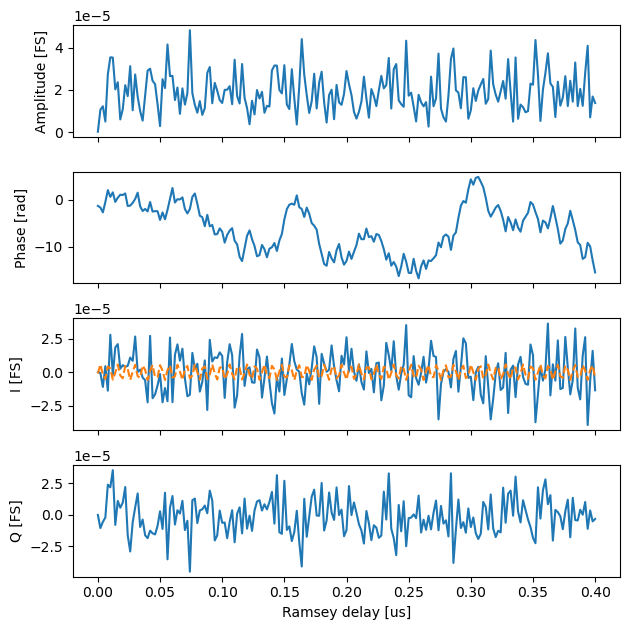

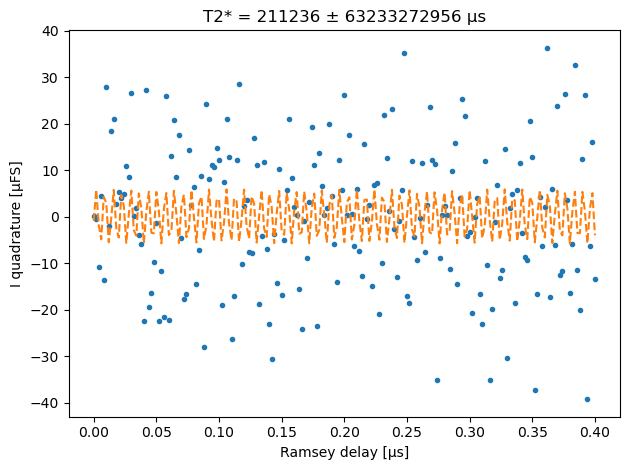

In [18]:
ramsey.analyze(all_plots = True)

<h2>Ramsey measurement, control amplitude variation</h2>
Perform a Ramsey-type spectroscopy for the measurement of the mode's coherence time.

In [10]:
from ramsey_amplitude import RamseyAmplitude
from IPPresto import ramsey_amplitude

In [14]:
readout_freq = f2
control_freq = f1
readout_amp = 0.1
readout_duration = 402e-9
control_duration = 202e-9
sample_duration = 402e-9
readout_port = 1
control_port = 2
sample_port = 1
wait_delay = 5e-6
readout_sample_delay = 2e-9

# delays
delay_start = 0
delay_stop = 0.8e-6
delay_points = 101
delays = np.linspace(delay_start, delay_stop, delay_points)

# amplitudes
control_start = 0.4
control_stop = 1
control_points = 21
control_amps =  np.linspace(control_start, control_stop, control_points)

num_averages = 50001

ramsey = RamseyAmplitude( readout_freq = readout_freq,
                          control_freq = control_freq,
                          readout_amp = readout_amp,
                          control_amps = control_amps,
                          readout_duration = readout_duration,
                          control_duration = control_duration,
                          sample_duration = sample_duration,
                          delay_arr = delays,
                          readout_port = 1,
                          control_port = 2,
                          sample_port = 1,
                          wait_delay = wait_delay,
                          readout_sample_delay = readout_sample_delay,
                          num_averages = num_averages )

mname = 's21_rf%.2e_cf%.2e_ra%.2f_cstrt%.2f_cstp%.2f_rd%.2e_cd%.2e_sd%.2e_del%.2fto%.2e_ndel%.2i_wd%.2e_rsd%.2e_avg%.2i' % ( readout_freq,
                                                                                                                 control_freq,
                                                                                                                 readout_amp,
                                                                                                                 control_start,
                                                                                                                 control_stop,
                                                                                                                 readout_duration/1e-9,
                                                                                                                 control_duration/1e-9,
                                                                                                                 sample_duration/1e-9,
                                                                                                                 delay_start/1e-9,
                                                                                                                 delay_stop/1e-9,
                                                                                                                 delay_points,
                                                                                                                 wait_delay/1e-9,
                                                                                                                 readout_sample_delay/1e-9,
                                                                                                                 num_averages ) 

ramsey_param = ramsey_amplitude( formatString(mname), presto, readout_freq, control_freq, readout_amp, control_amps, readout_duration, 
                              control_duration, sample_duration, delays, wait_delay, readout_sample_delay, num_averages )

In [15]:
measurement_name = "ramsey_r%.2e_c%.2e" % ( readout_freq, control_freq )
exp = load_or_create_experiment(experiment_name = measurement_name, sample_name = sample_name)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

meas.write_period = 10
meas.register_parameter(ramsey_param)

In [16]:
# averaging range in the sample time window, (0, 1) = average all
avg_range = (0.25, 1)

ramsey.run(ADDRESS);
data = ramsey.qc_analyze(avg_range)

# save in database
with meas.run() as datasaver:
    data = ramsey.qc_analyze(avg_range)
    datasaver.add_result((ramsey_param, data))

Measurement starting. Amplitudes done:  0   0.4 1   0.43000000000000005 2   0.46 3   0.49 4   0.52 5   0.55 6   0.5800000000000001 7   0.61 8   0.64 9   0.67 10   0.7 11   0.73 12   0.76 13   0.79 14   0.8200000000000001 15   0.85 16   0.88 17   0.91 18   0.9400000000000001 19   0.97 20   1.0 . Done.
Starting experimental run with id: 91. 


<h2>Ramsey-Chevron</h2>
Perform a Ramsey-type spectroscopy with variation of the control frequency.

In [10]:
from ramsey_chevron import RamseyChevron
from IPPresto import ramsey_chevron

In [20]:
readout_freq = f2
control_freq_center = f1
control_freq_span = 25e6
control_freq_nr = 101
readout_amp = 0.1
control_amp = 0.85
readout_duration = 402e-9
control_duration = 202e-9
sample_duration = 402e-9
readout_port = 1
control_port = 2
sample_port = 1
wait_delay = 5e-6
readout_sample_delay = 2e-9

# delays
delay_start = 0
delay_stop = 0.8e-6
delay_points = 101
delays = np.linspace(delay_start, delay_stop, delay_points)

num_averages = 101

ramchev = RamseyChevron( readout_freq = readout_freq,
                         control_freq_center = control_freq_center,
                         control_freq_span = control_freq_span,
                         control_freq_nr = control_freq_nr,
                         readout_amp = readout_amp,
                         control_amp = control_amp,
                         readout_duration = readout_duration,
                         control_duration = control_duration,
                         sample_duration = sample_duration,
                         delay_arr = delays,
                         readout_port = readout_port,
                         control_port = control_port,
                         sample_port = sample_port,
                         wait_delay = wait_delay,
                         readout_sample_delay = readout_sample_delay,
                         num_averages = num_averages )

mname = 's21_rf%.2e_cfc%.2e_cfs%.2e_cfn%.2i_ra%.2f_ca%.2f_rd%.2e_cd%.2e_sd%.2e_del%.2fto%.2e_ndel%.2i_wd%.2e_rsd%.2e_avg%.2i' % ( readout_freq,
                                                                                                                 control_freq_center,
                                                                                                                 control_freq_span,
                                                                                                                 control_freq_nr,                    
                                                                                                                 readout_amp,
                                                                                                                 control_amp,
                                                                                                                 readout_duration/1e-9,
                                                                                                                 control_duration/1e-9,
                                                                                                                 sample_duration/1e-9,
                                                                                                                 delay_start/1e-9,
                                                                                                                 delay_stop/1e-9,
                                                                                                                 delay_points,
                                                                                                                 wait_delay/1e-9,
                                                                                                                 readout_sample_delay/1e-9,
                                                                                                                 num_averages ) 

ramchev_param = ramsey_chevron( formatString(mname), presto, readout_freq, control_freq_center, control_freq_span, control_freq_nr, 
                                readout_amp, control_amp, readout_duration, control_duration, sample_duration, delays, 
                                wait_delay, readout_sample_delay, num_averages )

In [16]:
measurement_name = "ramsey_chevron_r%.2e_c%.2e" % ( readout_freq, control_freq_center )
exp = load_or_create_experiment(experiment_name = measurement_name, sample_name = sample_name)
meas = qc.Measurement(exp=exp, station=STATION, name = measurement_name)

meas.write_period = 10
meas.register_parameter(ramchev_param)

In [13]:
# averaging range in the sample time window, (0, 1) = average all
avg_range = (0.25, 1)

ramchev.run(ADDRESS);
data = ramchev.qc_analyze(avg_range)

# save in database
with meas.run() as datasaver:
    data = ramchev.qc_analyze(avg_range)
    datasaver.add_result((ramchev_param, data))

Measurement starting. Amplitudes done:  0 1 . Done.
Starting experimental run with id: 85. 


<h4>Test run (does not save data)</h4>

In [22]:
ramchev.run(ADDRESS)
ramchev.analyze()

ValueError: all `template` values must be in [-1.0; +1.0]

<h2>Rabi measurement</h2>